In [1]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy import stats

In [2]:
df = pd.read_csv("Data/properatti.csv", sep = ",")

In [27]:
# 1. Completar el precio por metro cuadrado en dolares mediante el valor de precio por metro cuadrado cuando el currency es usd
# https://gitlab.com/dsdh/properatti/issues/5
#uniques = df.currency.unique()
#uniques
print("Cantidad de precios USD nulos 1: ",len(df[df.price_usd_per_m2.isnull()==True]))
# condicion dolar 'USD'
usd = 'USD'; cond_currency_usd = (df.currency == usd)
# condicion dolar 'USD'
cond_notusdprice_m2 = df.price_usd_per_m2.isnull()
# condicion price_per_m2 definido
cond_price_m2 = df.price_per_m2.notnull()
#mascara
mask_price_1 = cond_currency_usd & cond_notusdprice_m2 & cond_price_m2
df_price = df[mask_price_1 == True]

print("----Cantidad a reemplazar: ",len(df_price))
df.price_usd_per_m2.update(df_price.price_per_m2)
print("Result ==> Cantidad de precios USD nulos luego: ",len(df[df.price_usd_per_m2.isnull()==True]))

#ejemplo
df.iloc[68]

Cantidad de precios USD nulos 1:  52603
----Cantidad a reemplazar:  21437
Result ==> Cantidad de precios USD nulos luego:  31166


Unnamed: 0                                                                   68
operation                                                                  sell
property_type                                                         apartment
place_name                                                        Mar del Plata
place_with_parent_names       |argentina|buenos aires costa atlántica|mar de...
country_name                                                          Argentina
state_name                                         Buenos Aires Costa Atlántica
geonames_id                                                         3.43086e+06
lat-lon                                                  -38.034794,-57.5416872
lat                                                                    -38.0348
lon                                                                    -57.5417
price                                                                    235000
currency                                

In [28]:
# 2. Calcular precio por metro cuadrado a partir de superficie
# https://gitlab.com/dsdh/properatti/issues/2
print("Cantidad de precios USD nulos 2: ",len(df[df.price_usd_per_m2.isnull()==True]))
# condicion en mask1
mask1 = (df.price_usd_per_m2.isnull())& (df.surface_covered_in_m2.notnull()) & (df.price_aprox_usd.notnull())
df1 = df[mask1]

print("----Cantidad a reemplazar: ",len(df1))
# Tal vez deberia hacerse la superficie total no la cubierta
x = df1.price_aprox_usd/df1.surface_covered_in_m2
df.price_usd_per_m2.update(x)
print("Result ==> Cantidad de precios USD nulos luego: ",len(df[df.price_usd_per_m2.isnull()==True]))

#ejemplo
df.iloc[154]

Cantidad de precios USD nulos 2:  31166
----Cantidad a reemplazar:  2871
Result ==> Cantidad de precios USD nulos luego:  28295


Unnamed: 0                                                                  154
operation                                                                  sell
property_type                                                         apartment
place_name                                                             Santa Fe
place_with_parent_names                           |argentina|santa fe|santa fe|
country_name                                                          Argentina
state_name                                                             Santa Fe
geonames_id                                                         3.83628e+06
lat-lon                                                   -31.622319,-60.705482
lat                                                                    -31.6223
lon                                                                    -60.7055
price                                                                   1.2e+06
currency                                

In [12]:
#7: Evaluamos si los tres tipos de propidad que existen son "house", "apartment" y "PH".
casas = df.loc[:,"property_type"] == "house"
print("Cantidad de casas: ",casas.sum())

apartamentos = df.loc[:,"property_type"] == "apartment"
print("Cantidad de apartamentos: ",apartamentos.sum())

ph = df.loc[:,"property_type"] == "PH"
print("Cantidad de ph: ", ph.sum())

tipopropiedad = casas & apartamentos & ph
print("Propiedad sin tipo: ",tipopropiedad.sum())


Cantidad de casas:  40268
Cantidad de apartamentos:  71065
Cantidad de ph:  5751
Propiedad sin tipo:  0


In [29]:
df.place_with_parent_names = df.place_with_parent_names.map(str.lower) #llevo a minusculas para evitar duplicados
grouped_places = df.groupby(['place_with_parent_names']) #agrupo por place_with_parent_names
dictio_places = grouped_places.groups.keys() #genero diccionario de places
cantidad_places = len(dictio_places) #cuento la cantidad de places distintos
print("Cantidad de place_with_parent_names distintos: ",cantidad_places)

count_x_places = grouped_places.agg({"operation": "count"}) #agrupo y cuento
count_x_places = count_x_places.rename(index=str, columns={"operation": "cantidad"}) #renombro la columna por cantidad
count_x_places = count_x_places.sort_values(by=['cantidad'], ascending=False) #ordeno por cantidad descendente

len(count_x_places.query("cantidad > 50")) # places con mas de <n> registros. Solo consulta


list_places = [sub_places.split('|') for sub_places in count_x_places.index]

df_places = pd.DataFrame(list_places, 
                         index = count_x_places.index, 
                         columns =['none1','pais','provincia','partido','localidad','barrio','none2']) 

    
#df_places.groupby(['none1']).count() # agrupo por primer columna para ver si hay algo. rs: no hay
#df_places.groupby(['pais']).count() # agrupo por pais para ver si algo no es argentina. rs: no hay
# agrupo por barrio para ver si hay mucha data distinta. rs: no aporta informacion. muchos vacios. ver si rellenar con API de coordenadas
#df_places.groupby(['barrio']).count()

df_places = df_places.drop(['none1', 'none2'], axis=1) # elimino none1 y none2
# Para cada columna busco vacios y asigno None
for column_name in df_places.columns:
    df_places[column_name][df_places[column_name].apply(lambda column_name: True if re.search('^\s*$', str(column_name)) else False)]=None

df_places = df_places.sort_values(by=['provincia','partido','localidad','barrio']) #ordeno
#df_places.where('provicia == capital');
df_places[(df_places.provincia == "capital federal")]

len(df_places.partido.unique())
#df_places.sample(20)

#analizar porque hay duplicados en true
#count_x_places.duplicated()

len(df_places.partido)




Cantidad de place_with_parent_names distintos:  1164


1164

iqr: 1268.2299465240642
q1: 1218.1818181818182
q3: 2486.4117647058824
median: 1800.0
Valor Left: -102.3449197860964  Cantidad de outliers: 0
Valor Right: 3702.3449197860964  Cantidad de outliers: 4452


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0.0, 1850.0)

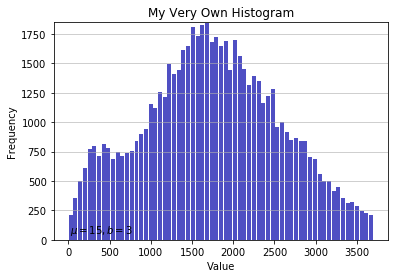

In [25]:
#q1_peso_usd_m2 = np.mean(price_usd_per_m2_arr) + 1*np.std(price_usd_per_m2_arr)
#q3_peso_usd_m2 = np.mean(price_usd_per_m2_arr) + 3*np.std(price_usd_per_m2_arr)

df_aux = df[df.price_usd_per_m2.notnull()] #elimino los nulos
q1_usd_m2, q3_usd_m2= np.percentile(df_aux.price_usd_per_m2,[25,75]) # obtengo q1 y q3
iqr_peso_usd_m2 = q3_usd_m2 - q1_usd_m2 #obtengo iqr
print("iqr:",iqr_peso_usd_m2)
print("q1:",q1_usd_m2)
print("q3:",q3_usd_m2)
median_price_usd_m2 = df_aux.price_usd_per_m2.median()
print("median:",median_price_usd_m2)


left_bound = median_price_usd_m2 -(1.5 * iqr_peso_usd_m2) 
right_bound = median_price_usd_m2 +(1.5 * iqr_peso_usd_m2) 


#df_aux.price_usd_per_m2[(np.abs(stats.zscore(df_aux.price_usd_per_m2)) < 3).all(axis=1)]

#print(left_bound,right_bound)
right_outliers = df_aux.price_usd_per_m2[np.abs(df_aux.price_usd_per_m2) > right_bound]
left_outliers = df_aux.price_usd_per_m2[np.abs(df_aux.price_usd_per_m2) < left_bound]
#left_outliers

print("Valor Left:",left_bound," Cantidad de outliers:",len(left_outliers))
print("Valor Right:",right_bound," Cantidad de outliers:",len(right_outliers))
#print(df_aux.price_usd_per_m2.describe())
df_aux = df_aux.drop(right_outliers.index)


right_outliers
#df_aux.iloc[57]

n, bins, patches = plt.hist(x=df_aux.price_usd_per_m2, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)



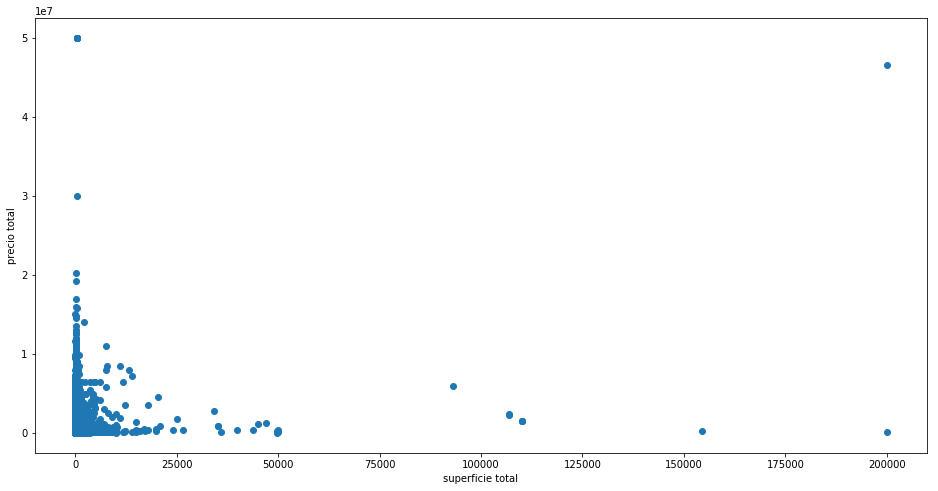

In [179]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df.surface_total_in_m2, df.price)
ax.set_xlabel('superficie total')
ax.set_ylabel('precio total')
plt.show()

In [22]:
# 1
# Relacion entre precio, cantidad de 
#         habitaciones y metros cuadrados cubiertos: Para saber en que punto tiene incidencia la cantidad de habitaciones

provincias = df.groupby("state_name").mean()
print(provincias)
barrios = df.groupby("place_name").mean()
print("cantidad de barrios:",len(barrios))

                                Unnamed: 0   geonames_id        lat  \
state_name                                                            
Bs.As. G.B.A. Zona Norte      57403.871557  3.432958e+06 -34.461298   
Bs.As. G.B.A. Zona Oeste      45997.683330  3.453478e+06 -34.644503   
Bs.As. G.B.A. Zona Sur        67393.747348  3.433987e+06 -34.803279   
Buenos Aires Costa Atlántica  47590.422646  3.455397e+06 -37.820371   
Buenos Aires Interior         47598.473592  3.618603e+06 -36.892797   
Capital Federal               61151.927095  3.528152e+06 -34.601818   
Catamarca                     35278.592593  3.845838e+06 -28.465495   
Chaco                         49302.105263  3.538969e+06 -27.452741   
Chubut                        83694.015444  3.852432e+06 -43.758762   
Corrientes                    86664.902230  3.433078e+06 -27.638352   
Córdoba                       74868.553733  3.855880e+06 -31.460336   
Entre Ríos                    53147.934959  3.461734e+06 -31.960400   
Formos

In [88]:
df_description = df[df.description.notnull()]

df_description = df_description.sample(60)

#description_array = df_description.description.str.lower()

pattern_amb = re.compile("(.*) amb")

def get_ambientes(row):
    pattern_amb = re.compile("(.*) amb")
    result = pattern_amb.search(row)
    if result:
        str_aux = result.group(1)
        array_amb = str_aux.split()
        cant_amb = array_amb[-1]
        if isinstance(cant_amb, int):
            print(cant_amb)
            return cant_amb
        else:
            return np.nan

        

df_description['cant_amb'] = df_description.apply(get_ambientes)
df_description

#for idx,desc in description_array.iteritems():


    
    
    
    
    



TypeError: ('expected string or bytes-like object', 'occurred at index Unnamed: 0')

In [35]:
#Rellenar con el promedio la superficie total, agrupando por el promedio del barrio (posible peso 39.328)
#https://gitlab.com/dsdh/properatti/issues/4

#Reemplazo los casos donde la superficie cubierta es 0 por nan
mask_surface_cov0 = (df.surface_covered_in_m2 == 0)
df.surface_covered_in_m2[mask_surface_cov0] = np.nan

#Reemplazo los casos donde la superficie total es 0 por nan
mask_surface_tot0 = (df.surface_total_in_m2 == 0)
df.surface_total_in_m2[mask_surface_tot0] = np.nan

###################################################################
# creamos una proporción de metros cubiertos sobre metros totales
propcubierto = df.surface_covered_in_m2 / df.surface_total_in_m2

# obteno proporciones validas (si es mayor a 1 no es una proporcion)
mask_propcubierto_validas = propcubierto < 1
propcubierto_clean  = propcubierto[mask_propcubierto_validas]

#Agrego la columna propcubierto al dataframe principal
df.propcubierto=propcubierto_clean

#agrupamos por provincia(state_name) el porcentaje promedio de propcubierto (m2cubierto/m2total)
avg_propcubiertobarrio = df.groupby('state_name')["propcubierto"].mean().sort_values(ascending = False)
print(avg_propcubiertobarrio)

#antes de hacer el reemplazo, evaluamos si los datos que tenemos para aplicar el promedio cumple con un mínimo
#que lo haga fiable. Establecemos dos exigencias
# UNO - Que haya mas de 30 datos para obtener la proporción 
# DOS - Que la proporcion de datos disponibles sea mayor al 25%

#cantidad de datos para calcular la proporcion 
avg_propcubiertobarriocount = df.groupby('state_name')["propcubierto"].count().sort_values(ascending = False)

#mascara para obtener los que no tienen mas de 30 registros
mask_removerporcantidad = avg_propcubiertobarriocount > 30

#cantidad de datos existentes en tabla
mask_surface_notnull = df.surface_covered_in_m2.notnull()
df_recup_suf_tot = df[mask_surface_notnull].groupby('state_name')['state_name'].count().sort_values(ascending = False)

#divido los datos existentes sobre los datos totales y obtengo la relación para la regla DOS
proporcion = avg_propcubiertobarriocount / df_recup_suf_tot
proporcion.round(2).sort_values(ascending = True)

#condición de la regla 2
mask_removerporproporcion = proporcion > 0.25

#genero máscara con ambas condiciones
mask_proporcion = mask_removerporcantidad & mask_removerporproporcion
propvalidados = avg_propcubiertobarrio[mask_proporcion]
print ('estos son los que cumplen las dos condiciones y son fiables para el reemplazo', avg_propcubiertobarrio[mask_proporcion])

#iteramos por las propiedades que tienen el dato faltante de superficie total y les inputamos la proporción promedio
#del barrio al que pertenecen, usando como dato la superficie cubierta.
# SUPERFICIE TOTAL = (SUPERFICIE CUBIERTA / PROPORCION CUBIERTOTOTAL)

# TODO: Mejorar con apply
surface_total_in_m2_clean = []
for index, row in df.iterrows():
    if pd.isnull(row.surface_total_in_m2):    
        if(propvalidados.index.contains(row.state_name)):        
            #surface_total_in_m2_clean.append(row.surface_covered_in_m2 / avg_propcubiertobarrio[row.state_name]) VERSION DE PAULA CORRE
            surface_total_in_m2_clean.append(row.surface_covered_in_m2 / propvalidados.loc[row.state_name]) #VERSION CON PROPVALIDADOS NO CORRE
        else:
            surface_total_in_m2_clean.append(row.surface_total_in_m2)    
    else:
        surface_total_in_m2_clean.append(row.surface_total_in_m2)

df["surface_total_in_m2_nueva"] = surface_total_in_m2_clean

#dropeamos los casos NaN
surfacetotalnueva_notnull = df.surface_total_in_m2_nueva.dropna()

#y finalmente, los reemplazamos en la columna "surface_total_in_m2_nueva" original del DF
df.surface_total_in_m2.update(surfacetotalnueva_notnull)


#df[['surface_total_in_m2', 'surface_total_in_m2_nueva']]
#verifico si son iguales, donde no coinciden levanta los casos nan unicamente pero en relaidad son iguales
#maskcheck = df.surface_total_in_m2 != df.surface_total_in_m2_nueva
#asdasd = df[maskcheck]
#asdasd[['surface_total_in_m2', 'surface_total_in_m2_nueva']]
#mask1 = (df.surface_total_in_m2.isnull()) & (df.surface_covered_in_m2.notnull()) 
#dfmaskk1 = df[mask1]
#dfmaskk1[['surface_total_in_m2', 'surface_covered_in_m2','state_name', 'surface_total_in_m2_nueva']].head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


state_name
Capital Federal                 0.833831
Santa Fe                        0.752178
Neuquén                         0.734619
Bs.As. G.B.A. Zona Sur          0.720536
Bs.As. G.B.A. Zona Norte        0.689866
Córdoba                         0.678031
Río Negro                       0.674219
Buenos Aires Costa Atlántica    0.669633
Tucumán                         0.658362
San Juan                        0.656184
Corrientes                      0.650579
Chaco                           0.635503
Bs.As. G.B.A. Zona Oeste        0.624836
Chubut                          0.611554
Santa Cruz                      0.609108
Tierra Del Fuego                0.565032
Entre Ríos                      0.545258
Salta                           0.530071
La Pampa                        0.520446
Buenos Aires Interior           0.500039
Mendoza                         0.496813
Misiones                        0.480108
Catamarca                       0.463895
San Luis                        0.428273
Santi

In [57]:
pattern_amb = re.compile("(.*) amb")

def get_ambientes(row):
    result = pattern_amb.search(row.description)
    if result:
        print result.group(1)

df_description.description.apply(get_ambientes)

#for idx,desc in description_array.iteritems():

ValueError: invalid literal for int() with base 10: 'amb.los'